In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.colors as mcolors
import cartopy.feature as cfeature

In [8]:
def plot(values, name, scale):
    u, v, z, wind_speed, lon, lat = values

    # Custom white → blue → green → yellow → red colormap
    colors = ["white", "blue", "green", "yellow", "red"]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_wbgr", colors, N=256)

    proj = ccrs.LambertConformal(central_longitude=-30, central_latitude=50)
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})
    ax.set_extent([-90, 30, 0, 75], crs=ccrs.PlateCarree())  # Covers N. America → Europe
    # Longitude: −90° to 30° (roughly from East Canada to Eastern Europe)

    # Latitude: 20° to 75° (Caribbean to Northern Europe)

    # Filled wind speed contours
    cf = ax.contourf(
        lon,
        lat,
        wind_speed,
        levels=20,
        cmap=custom_cmap,
        extend="max",
        alpha=0.3,
        transform=ccrs.PlateCarree(),
    )

    # Geopotential height contours
    cs = ax.contour(
        lon,
        lat,
        z,
        levels=20,
        colors="black",
        linewidths=0.8,
        transform=ccrs.PlateCarree(),
    )
    ax.clabel(cs, inline=True, fontsize=8, fmt="%d")

    # Wind vectors
    # lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    ax.quiver(
        lon,
        lat,
        u,
        v,
        scale=scale,
        alpha=0.7,
        transform=ccrs.PlateCarree(),
    )

    # Map features
    ax.coastlines(resolution="50m", color="black", linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor="#C69930", alpha=0.2)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.2)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5)
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {"size": 10}
    gl.ylabel_style = {"size": 10}

    # Title & Colorbar
    # pressure_str = int(getattr(u, "pressure_level", 500))  # fallback if missing
    # plt.title(f"{pressure_str} hPa: Wind Speed (m/s), Geopotential Height (gpm)", fontsize=12)

    plt.colorbar(
        cf,
        ax=ax,
        orientation="horizontal",
        pad=0.05,
        label="Wind Speed (m/s)",
        shrink=0.5,
    )
    plt.tight_layout
    plt.savefig(f"../images/{name}.png", bbox_inches="tight")
    plt.savefig(f"../images/{name}.pdf", bbox_inches="tight")
    plt.show()



In [18]:
def plot_beta_plane(values, name, scale=1e6):
    u, v, z, wind_speed, x, y = values

    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Contour of streamfunction (or height field)
    cs = ax.contour(x / 1000, y / 1000, z, levels=20, colors='black', linewidths=0.8)
    ax.clabel(cs, inline=True, fontsize=8, fmt="%.0f")

    # Filled wind speed
    cf = ax.contourf(x / 1000, y / 1000, wind_speed, levels=20, cmap="coolwarm", alpha=0.4)

    # Quiver plot
    ax.quiver(x / 1000, y / 1000, u, v, scale=scale, alpha=0.8)

    ax.set_xlabel("x [km]")
    ax.set_ylabel("y [km]")
    ax.set_title("Rossby-Welle auf der β-Ebene")
    plt.colorbar(cf, ax=ax, label="Windgeschwindigkeit [m/s]")

    plt.tight_layout()
    plt.savefig(f"../images/{name}.png", bbox_inches="tight")
    plt.savefig(f"../images/{name}.pdf", bbox_inches="tight")
    plt.show()


In [ ]:
def zonal_wind(theta, phi):
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Latitude-dependent zonal wind (eastward)
    U0 = 50  # m/s, just for visible effect
    u = U0 * np.sin(theta_grid)**2
    v = np.zeros_like(u)

    # Convert to latitude and longitude in degrees
    lat = 90 - np.degrees(theta_grid)
    lon = np.degrees(phi_grid)

    # Compute wind speed
    wind_speed = np.sqrt(u**2 + v**2)

    # Use a representative geopotential field (e.g., idealized height)
    z = 5000  + 0 * np.sin(theta_grid)**2  # dummy field
    
    return u, v, z, wind_speed, lon, lat

theta = np.linspace(0, np.pi, 45)        # colatitude
phi = np.linspace(0, 2 * np.pi, 45)     # longitude

values = zonal_wind(theta, phi)
name = "zonal_wind_plot"
plot(values, name, scale=900)

In [ ]:
def meridional_wind(theta, phi):
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Latitude-dependent meridional wind (northward)
    V0 = 30  # m/s, just for visible effect
    v = V0 * np.cos(theta_grid)
    u = np.zeros_like(v)

    # Convert to latitude and longitude in degrees
    lat = 90 - np.degrees(theta_grid)
    lon = np.degrees(phi_grid)

    # Compute wind speed
    wind_speed = np.sqrt(u**2 + v**2)

    # Use a representative geopotential field (e.g., idealized height)
    z = 5000 + 0 * np.cos(theta_grid)  # dummy field
    
    return u, v, z, wind_speed, lon, lat

theta = np.linspace(0, np.pi, 45)        # colatitude
phi = np.linspace(0, 2 * np.pi, 45)     # longitude
values = meridional_wind(theta, phi)
name = 'meridional_wind_plot'
plot(values, name, scale=900)

In [4]:
def coriolis_effect(theta, phi, steps=100, dt=100):
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    # Convert to latitude
    lat = 90 - np.degrees(theta_grid)
    lon = np.degrees(phi_grid)

    # Earth's rotation
    Omega = 7.2921e-5  # rad/s
    f = 2 * Omega * np.sin(np.radians(lat))  # Coriolis parameter at each lat

    # Initialize velocities (northward motion)
    v = np.full_like(f, 1.0)  # northward
    u = np.zeros_like(f)       # no zonal motion

    # Initialize displacements
    dx = np.zeros_like(f)
    dy = np.zeros_like(f)

    for _ in range(steps):
        # Update velocities using Coriolis force
        u_new = u + f * v * dt
        v_new = v - f * u * dt

        # Update positions
        dx += u_new * dt
        dy += v_new * dt

        # Advance state
        u, v = u_new, v_new

    # Optional wind speed
    wind_speed = np.sqrt(u**2 + v**2)

    # Dummy geopotential
    z = 5000 * np.ones_like(u)

    return u, v, z, wind_speed, lon, lat, dx, dy

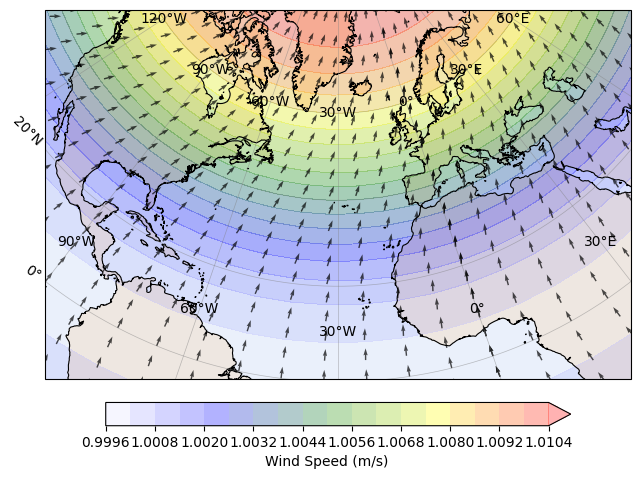

In [9]:
theta = np.linspace(0, np.pi, 45)        # colatitude
phi = np.linspace(0, 2 * np.pi, 45)     # longitude

# values = zonal_wind(theta, phi)
# values = meridional_wind(theta, phi)
u, v, z, wind_speed, lon, lat, dx, dy = coriolis_effect(theta, phi, steps=100, dt=100)
values = (dx, dy, z, wind_speed, lon, lat)
name = 'coriolis_effect_plot'
plot(values, name, scale=500000)


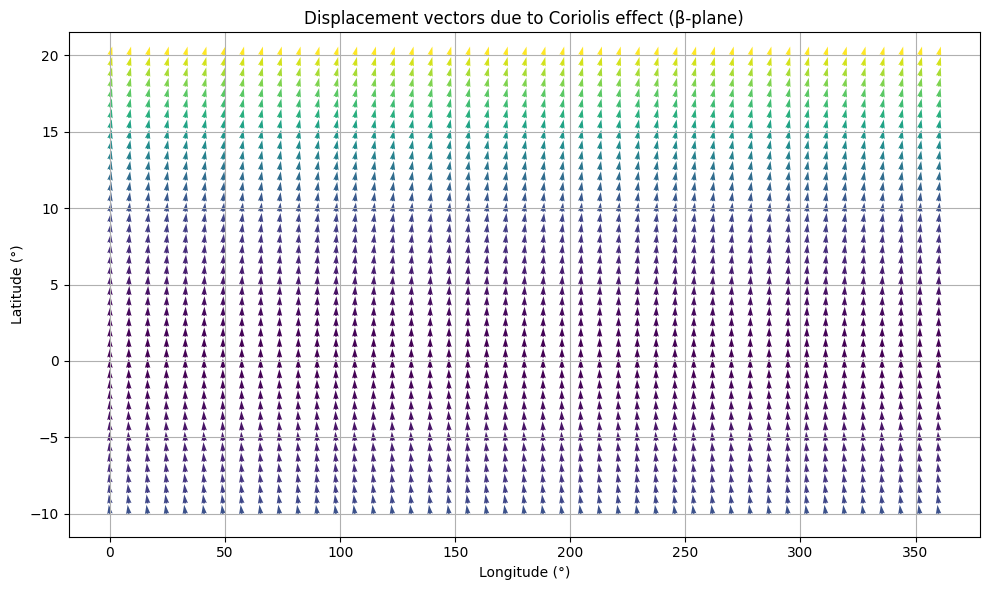

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def coriolis_effect_beta_plane(theta, phi, steps=100, dt=100):
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # Convert to latitude (degrees) and define grid
    lat = 90 - np.degrees(theta_grid)
    lon = np.degrees(phi_grid)

    # Earth's constants
    Omega = 7.2921e-5  # rad/s
    a = 6.371e6        # Earth radius in meters
    phi0 = 5          # Reference latitude for beta-plane (deg)

    # Coriolis parameters
    f0 = 2 * Omega * np.sin(np.radians(phi0))
    beta = 2 * Omega * np.cos(np.radians(phi0)) / a

    # y-distance from reference latitude (in meters)
    y = np.radians(lat) * a
    y0 = np.radians(phi0) * a
    f = f0 + beta * (y - y0)  # linear approximation

    # Initial conditions
    v = np.full_like(f, 1.0)
    u = np.zeros_like(f)
    dx = np.zeros_like(f)
    dy = np.zeros_like(f)

    # Time-stepping loop
    for _ in range(steps):
        u_new = u + f * v * dt
        v_new = v - f * u * dt
        dx += u_new * dt
        dy += v_new * dt
        u, v = u_new, v_new

    z = 5000 * np.ones_like(u)
    wind_speed = np.sqrt(u**2 + v**2)

    return dx, dy, lon, lat, wind_speed

# Grid definition
phi0 = 5  # reference latitude
lat_deg = np.linspace(-10, 20, 45)  # 10-degree band
lon_deg = np.linspace(0, 360, 45)

# Convert to theta, phi (in radians)
theta = np.radians(90 - lat_deg)  # colatitude
phi = np.radians(lon_deg)    

# Run simulation
dx, dy, lon, lat, wind_speed = coriolis_effect_beta_plane(theta, phi)

# Plot with quiver
plt.figure(figsize=(10, 6))
plt.quiver(lon, lat, dx, dy, wind_speed, scale=1e6)
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.title("Displacement vectors due to Coriolis effect (β-plane)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def rossby_wave(theta, phi):
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    
    # Parameters for Rossby wave
    k = 4  # zonal wave number
    beta = 2e-11  # beta parameter (1/m/s)
    U0 = 50  # mean zonal wind (m/s)
    a = 6.4e6  # Earth radius

    # Streamfunction with Rossby wave pattern
    psi_hat = 50000  # amplitude of the streamfunction
    psi = psi_hat * np.cos(k * phi_grid) * np.sin(theta_grid)

    # Derive wind field: u = -∂ψ/∂y, v = ∂ψ/∂x (spherical)
    dphi = phi[1] - phi[0]
    dtheta = theta[1] - theta[0]

    dpsi_dtheta = np.gradient(psi, dtheta, axis=0) / a
    dpsi_dphi = np.gradient(psi, dphi, axis=1) / (a * np.sin(theta_grid))

    u = -dpsi_dtheta
    v = dpsi_dphi

    # For display purposes
    lat = 90 - np.degrees(theta_grid)
    lon = np.degrees(phi_grid)
    wind_speed = np.sqrt(u**2 + v**2)
    z = psi  # Use streamfunction as proxy for height

    return u, v, z, wind_speed, lon, lat

theta = np.linspace(0.2, np.pi - 0.2, 45)
phi = np.linspace(0, 2 * np.pi, 90)

values = rossby_wave(theta, phi)
name = "rossby_wave_plot"
plot(values, name, scale=900)


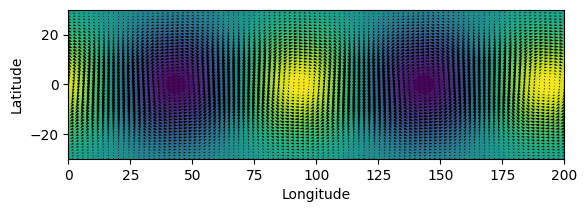

In [23]:
def rossby_wave_beta_plane_time(x, y, t):
    x_grid, y_grid = np.meshgrid(x, y)

    # Wellenparameter
    k = 2 * np.pi / 10e6   # zonale Wellenlänge ~10,000 km
    beta = 2e-11           # 1/(m·s)
    psi_hat = 5e5          # Amplitude
    y0 = 0                 # Jet-Zentrum
    sigma = 1.5e6          # Breite des Jets

    # Dispersionsrelation für l = 0
    omega = -beta * k / (k**2)

    # Mäandernder Jet: gaussförmig in y, sinusförmig in x, zeitabhängig
    envelope = np.exp(-((y_grid - y0)**2) / (2 * sigma**2))
    psi = psi_hat * np.cos(k * x_grid - omega * t) * envelope

    # Ableitungen
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dpsi_dy = np.gradient(psi, dy, axis=0)
    dpsi_dx = np.gradient(psi, dx, axis=1)

    u = -dpsi_dy
    v = dpsi_dx

    lon = x_grid / 1e5
    lat = y_grid / 1e5
    wind_speed = np.sqrt(u**2 + v**2)
    z = psi

    return u, v, z, wind_speed, lon, lat

x = np.linspace(0, 2e7, 100)  # 0 bis 20,000 km
y = np.linspace(-3e6, 3e6, 50)  # ±3000 km um den Jet

u, v, psi, wind, lon, lat = rossby_wave_beta_plane_time(x, y, t=1e6)

plt.contourf(lon, lat, psi, levels=30)
plt.quiver(lon, lat, u, v)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.gca().set_aspect('equal')
plt.show()

